# Larger Arrays with Blockade Approximation

## Implementing the Blockade Approximation

We perform the adiabatic evolution in the blockade subspace. 

In [1]:
using Bloqade
using PythonCall
using KrylovKit
using SparseArrays

plt = pyimport("matplotlib.pyplot");

In [2]:
# specify the adiabatic pulse sequence for Rabi frequency
total_time = 6.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 5.1, 5.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]);

In [3]:
# create detuning sequence
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 5.1, total_time], values = [U1, U1, U2, U2]);

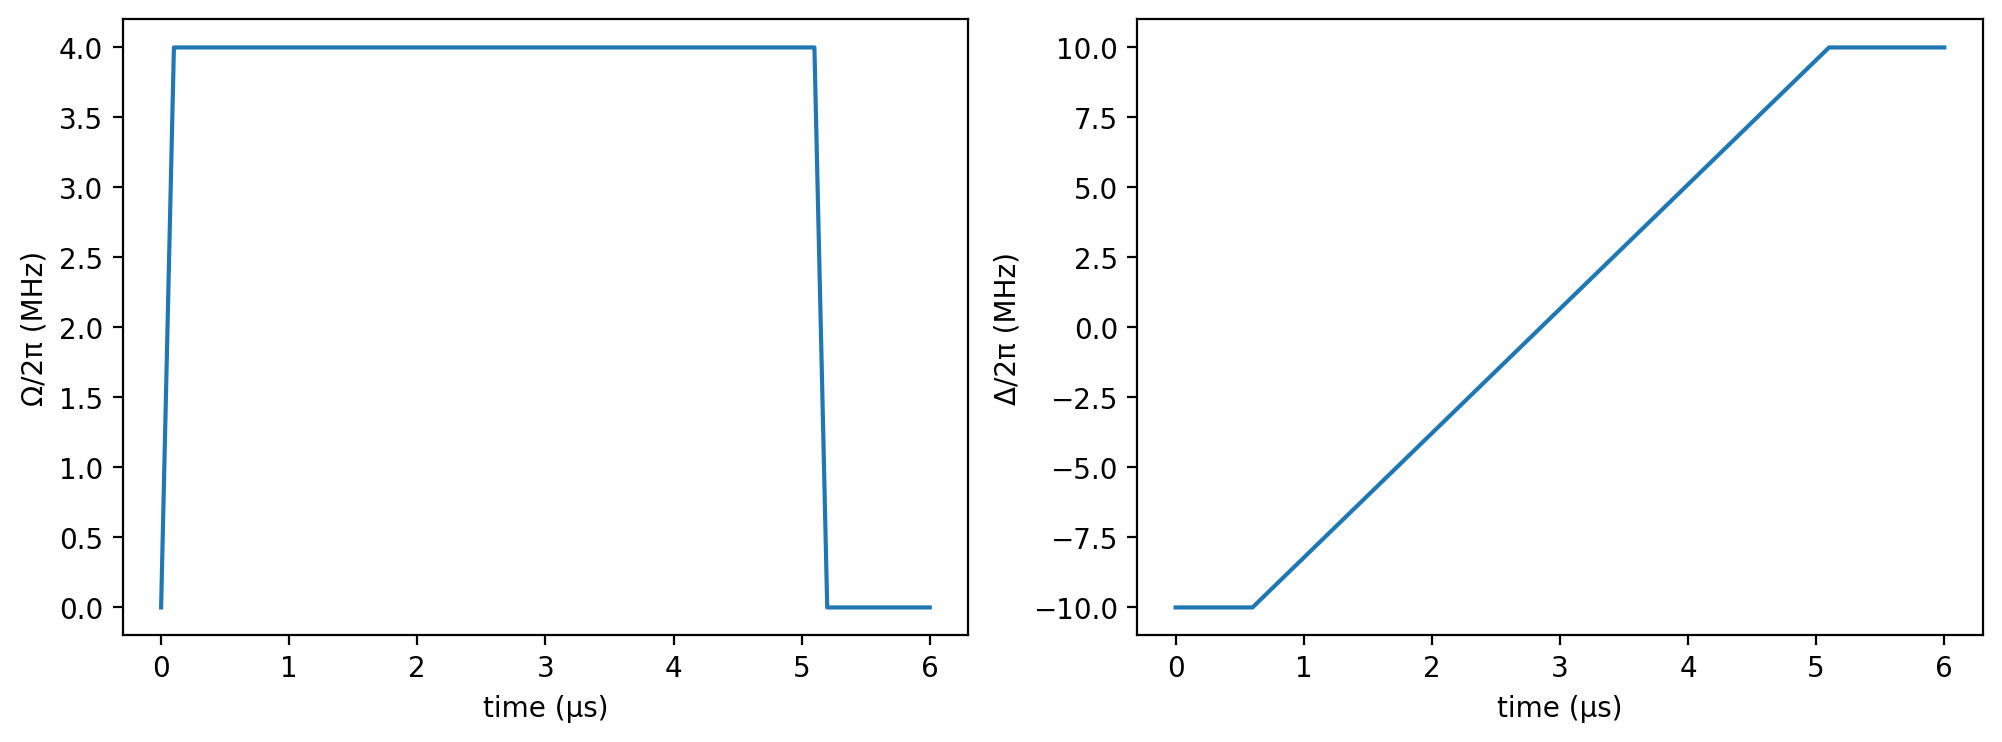

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

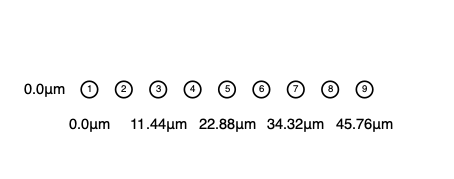

In [5]:
# generate positions of 1D atom chain
nsites = 9
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

In [12]:
# set subspace radius to be slightly bigger than the atom seperation
subspace_radius = 5.73
space = blockade_subspace(atoms, subspace_radius)
init_state_sub = zero_state(space) # initial state in subspace
init_state_full = zero_state(9) # initial state in full space

ArrayReg{2, ComplexF64, Array...}
    active qubits: 9/9
    nlevel: 2

In [7]:
# time-dependent Hamiltonian
h = rydberg_h(atoms; Δ, Ω)

nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


In [13]:
# subspace evolution
# choose an ODE solver
prob_sub = SchrodingerProblem(init_state_sub, total_time, h);
integrator_sub = init(prob_sub, Vern8());

In [14]:
densities = []
dens1_sub = []
for _ in TimeChoiceIterator(integrator_sub, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(init_state_sub))
    push!(dens1_sub, rydberg_density(init_state_sub, 1))
end
D = hcat(densities...);

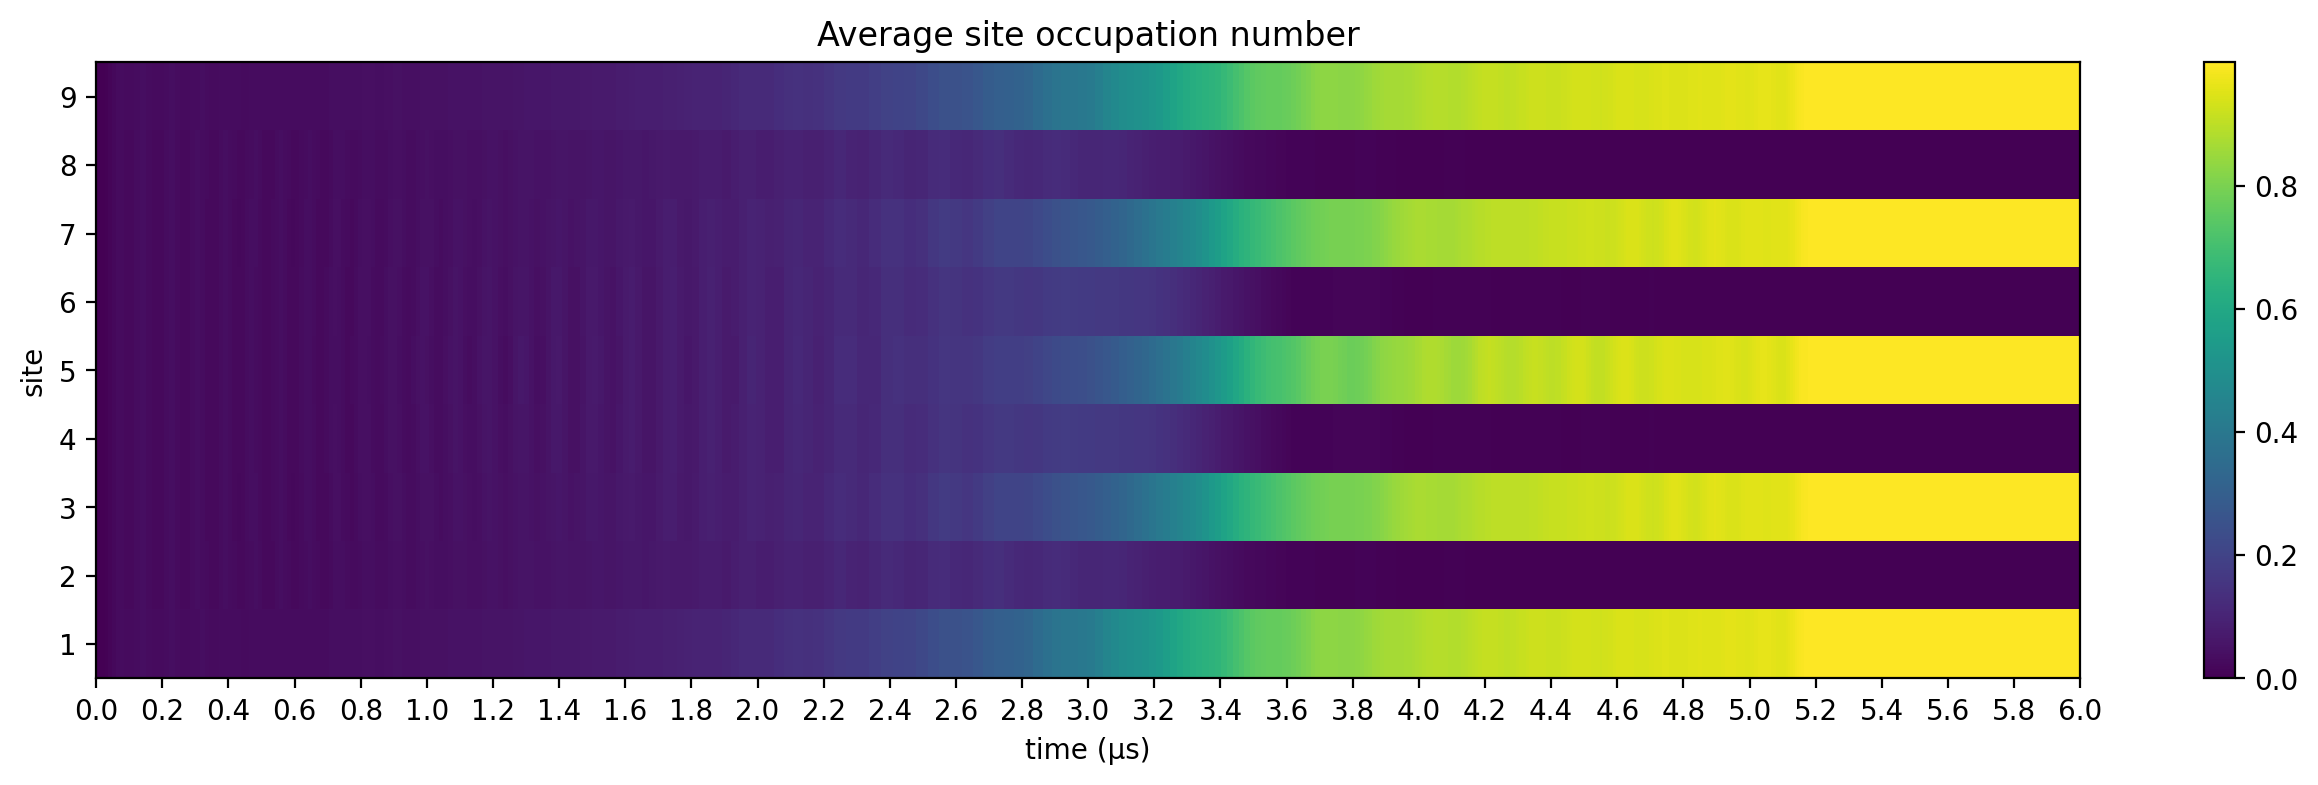

In [18]:
fig, ax = plt.subplots(figsize = (16, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
plt.title("Average site occupation number")
fig

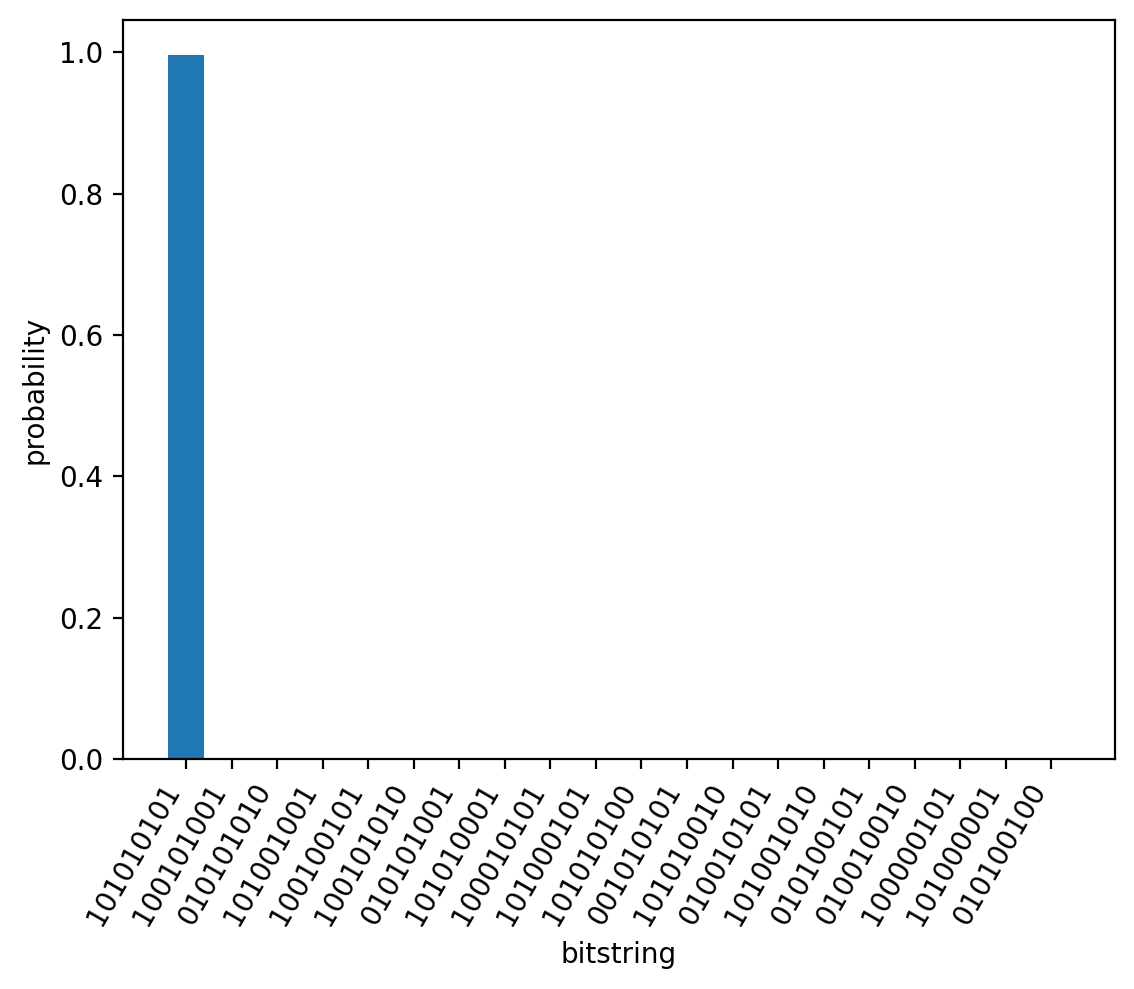

In [16]:
# view the final state via measurement
bitstring_hist(init_state; nlargest = 20)

In [19]:
# full space evolution
# choose an ODE solver
prob_full = SchrodingerProblem(init_state_full, total_time, h);
integrator_full = init(prob_full, Vern8());

In [20]:
dens1_full = []
for _ in TimeChoiceIterator(integrator_full, 0.0:1e-3:total_time)
    push!(dens1_full, rydberg_density(init_state_full, 1))
end

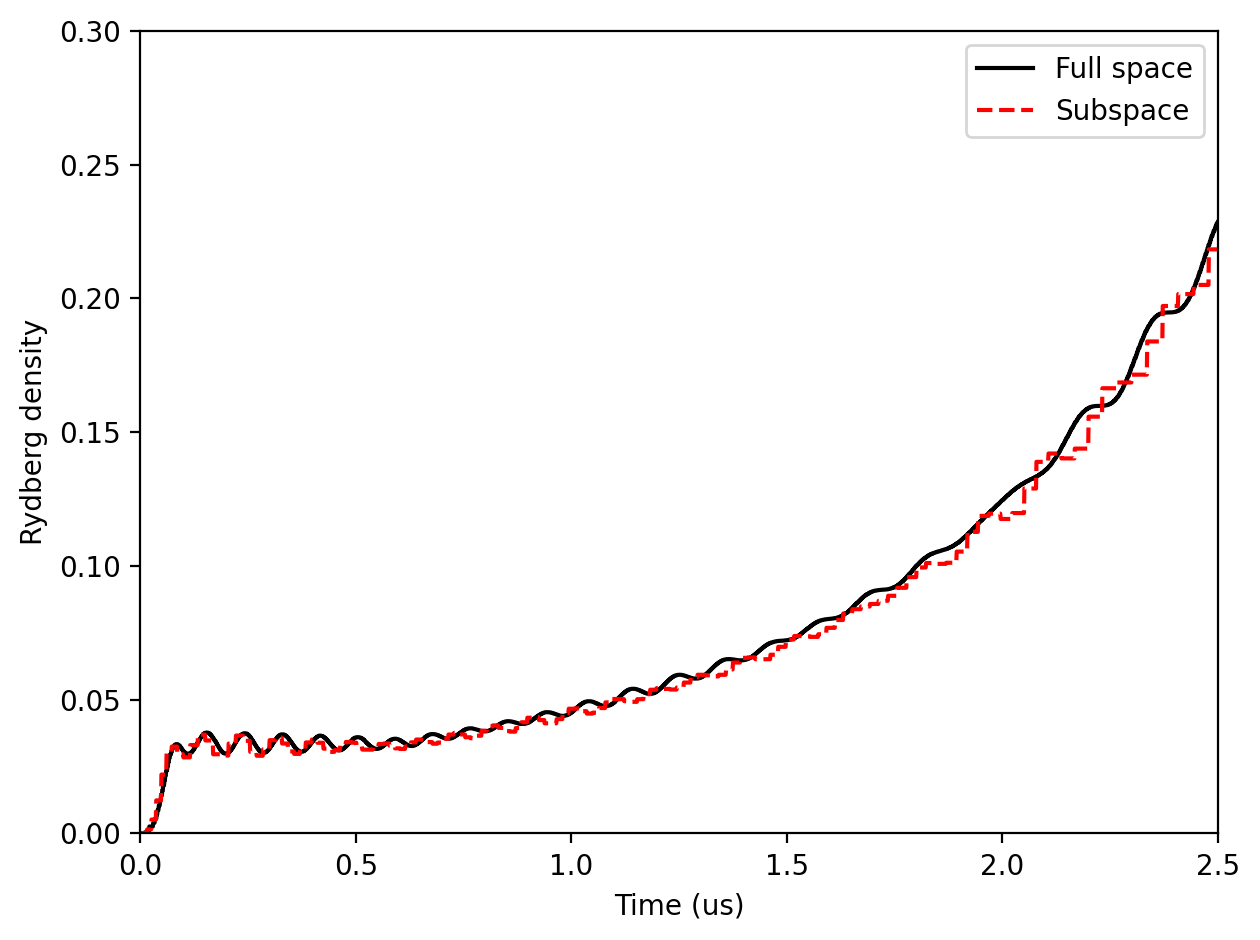

In [33]:
times = LinRange(0, total_time, 6001)
fig1, ax = plt.subplots()
plt.plot(times, real(dens1_full), "k", label = "Full space")
plt.plot(times, real(dens1_sub), "r--", label = "Subspace")
ax.axis([0, 2.5, 0,0.3])
plt.xlabel("Time (us)")
plt.ylabel("Rydberg density")
plt.tight_layout()
plt.legend()
fig1

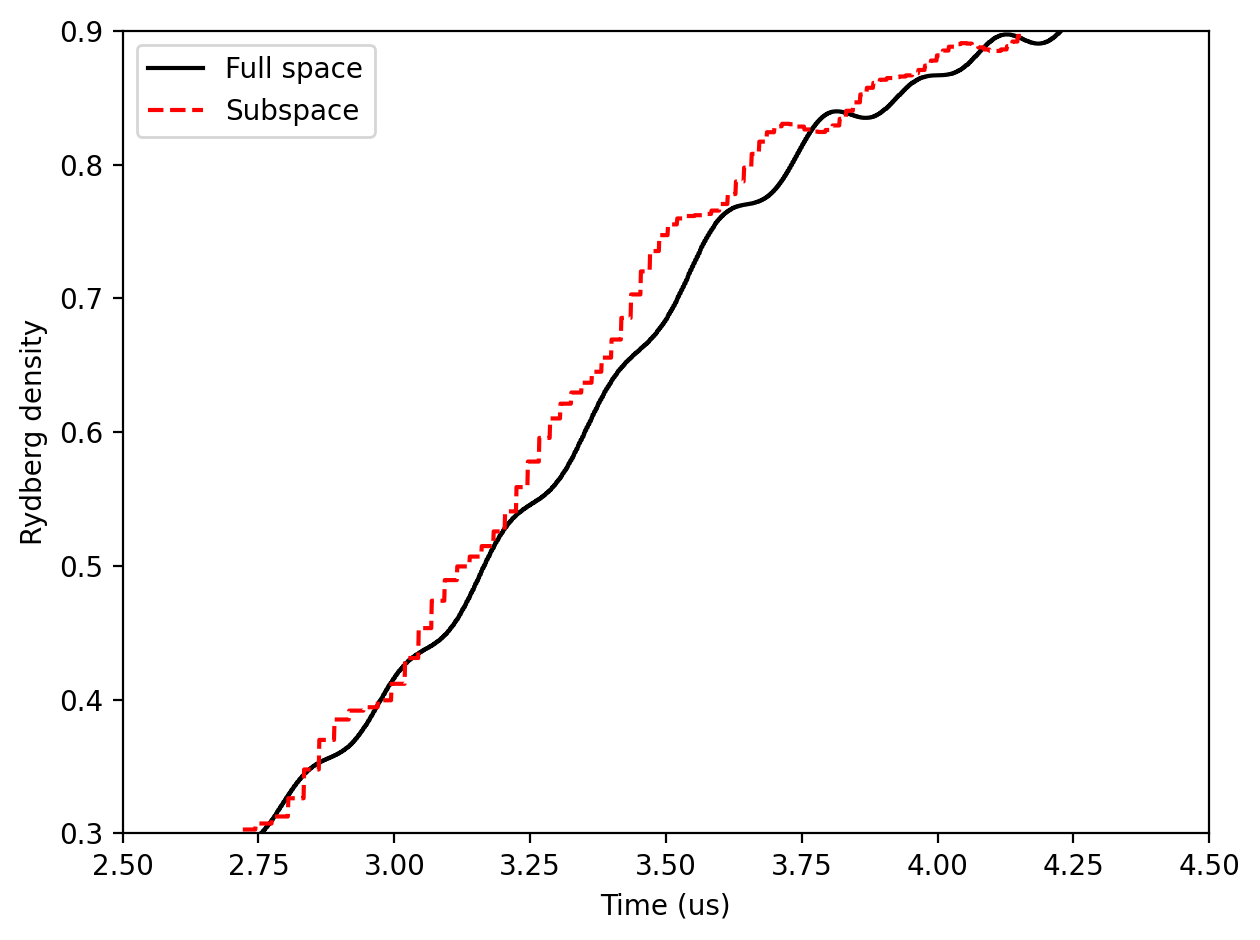

In [32]:
times = LinRange(0, total_time, 6001)
fig2, ax = plt.subplots()
plt.plot(times, real(dens1_full), "k", label = "Full space")
plt.plot(times, real(dens1_sub), "r--", label = "Subspace")
ax.axis([2.5, 4.5, 0.3, 0.9])
plt.xlabel("Time (us)")
plt.ylabel("Rydberg density")
plt.tight_layout()
plt.legend()
fig2

The two plots above show the Rydberg density of the first qubit in the subspace vs. in the full space. We can see that the evolution in the subspace matches the full space evolution well for a short period of time. It starts deviating from the full space evolution from $\sim 2\text{ sec}$ and diverges further after $\sim 3\text{ sec}$. Therefore the blockade approximation works well only on short time scales.

The effective Rabi frequency of 1D atom arrays scales as $\sim\sqrt{N}$ where $N$ number of qubits (refrences [1](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.95.041801) & [2](https://www.nature.com/articles/nature24622)).

$
|E_1-E_0|/\hbar=\sqrt{N}\Omega_r
$

where $\Omega_r$ is the Rabi frequency.

To successfully prepare the $\mathbb{Z}_2$ state with this computor, the nearest-neighbor interaction between atoms has to be much greater than the Rabi frequency $V_{i, i+1}\gg\sqrt{N}\Omega$. Our hypothesis is that the $\mathbb{Z}_2$ state would not be correctly simulated if the effective Rabi frequency $\sqrt{N}\Omega_r$ becomes comparable to the nearest-neighbot interaction strength. In our previous simulation, $V_{i, i+1}=2\pi\cdot 24\text{ MHz}$ and $\Omega_r = 2\pi\cdot 4\text{ MHz}$. The effective Rabi frequency becomes comparable to $V_{i,i+1}$ when $N=36$. So the maximum possible array should have around that number of qubits.

We believe that same logic should work for a 2D array. The only parameter of importance would be the correct value of $a$ which sets the nearest-neighbor interaction strength and the checkerboard pattern. 